In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, StructType, StructField, TimestampType, IntegerType
from pyspark.sql.functions import from_json, col
import time

# Define the path to the jars on the EC2 instance
spark_jars_path = "/home/ec2-user/stream-processing-template/jars"  # <-- Update this path

spark = SparkSession.builder.appName("retail_pysaprk_consumer") \
    .config("spark.jars", f"{spark_jars_path}/commons-pool2-2.11.1.jar,"
            f"{spark_jars_path}/spark-sql-kafka-0-10_2.12-3.4.0.jar,"
            f"{spark_jars_path}/spark-streaming-kafka-0-10-assembly_2.12-3.4.0.jar") \
    .getOrCreate()


23/12/15 15:21:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
/usr/local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [2]:
# Define the schema for our data
schema = StructType([
    StructField("store_location", StringType(), True),
    StructField("time_of_purchase", TimestampType(), True),
    StructField("product_ID", StringType(), True),
    StructField("transaction_amount", IntegerType(), True)
])

# Stream from Kafka topic
df = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "b-1.monstercluster1.6xql65.c3.kafka.eu-west-2.amazonaws.com:9092") \
    .option("subscribe", "retail_transactions") \
    .load()

In [3]:
transactions = (df.selectExpr("CAST(value AS STRING)")
                .withColumn("data", from_json(col("value"), schema))
                .select("data.*"))

query = transactions.writeStream \
.format("memory") \
.queryName("temporary_view_three") \
.start()

query.awaitTermination(30)



23/12/15 15:21:28 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-3f24401c-0c9e-49f3-a800-649ed74ed9ea. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/12/15 15:21:28 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/12/15 15:21:30 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


False

In [4]:
processed_data = spark.sql("SELECT * FROM temporary_view_three")

In [5]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

transactions = processed_data.withColumn("transaction_amount", col("transaction_amount").cast(DoubleType()))

In [6]:
transactions.show()

+--------------+-------------------+----------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount|
+--------------+-------------------+----------+------------------+
|  Philadelphia|2023-12-15 15:21:32|    P00046|             874.0|
|  Philadelphia|2023-12-15 15:21:33|    P00097|             496.0|
|   Los Angeles|2023-12-15 15:21:36|    P00082|               5.0|
|  Philadelphia|2023-12-15 15:21:37|    P00076|             188.0|
|      New York|2023-12-15 15:21:39|    P00016|             524.0|
|       Phoenix|2023-12-15 15:21:41|    P00094|             271.0|
|   Los Angeles|2023-12-15 15:21:43|    P00043|             663.0|
|      New York|2023-12-15 15:21:44|    P00029|             627.0|
|       Phoenix|2023-12-15 15:21:46|    P00042|            -257.0|
|      New York|2023-12-15 15:21:48|    P00090|             101.0|
|   San Antonio|2023-12-15 15:21:50|    P00057|             181.0|
|  Philadelphia|2023-12-15 15:21:53|    P00023|             28

In [7]:
from pyspark.sql.functions import sum
total_transactions = transactions.groupBy("store_location").agg(sum("transaction_amount").alias("total_amount"))
total_transactions.show()

+--------------+------------+
|store_location|total_amount|
+--------------+------------+
|       Phoenix|       602.0|
|   San Antonio|       587.0|
|  Philadelphia|      1840.0|
|   Los Angeles|       668.0|
|      New York|      1374.0|
+--------------+------------+



In [8]:
with_discount = transactions.withColumn("discounted_amount", col("transaction_amount") * 0.9)
with_discount.show()

+--------------+-------------------+----------+------------------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount| discounted_amount|
+--------------+-------------------+----------+------------------+------------------+
|  Philadelphia|2023-12-15 15:21:32|    P00046|             874.0|             786.6|
|  Philadelphia|2023-12-15 15:21:33|    P00097|             496.0|446.40000000000003|
|   Los Angeles|2023-12-15 15:21:36|    P00082|               5.0|               4.5|
|  Philadelphia|2023-12-15 15:21:37|    P00076|             188.0|169.20000000000002|
|      New York|2023-12-15 15:21:39|    P00016|             524.0|             471.6|
|       Phoenix|2023-12-15 15:21:41|    P00094|             271.0|             243.9|
|   Los Angeles|2023-12-15 15:21:43|    P00043|             663.0|             596.7|
|      New York|2023-12-15 15:21:44|    P00029|             627.0| 564.3000000000001|
|       Phoenix|2023-12-15 15:21:46|    P00042|       

In [9]:
with_discount.filter(with_discount.store_location == 'online').show()

+--------------+----------------+----------+------------------+-----------------+
|store_location|time_of_purchase|product_ID|transaction_amount|discounted_amount|
+--------------+----------------+----------+------------------+-----------------+
+--------------+----------------+----------+------------------+-----------------+



In [10]:
with_discount.filter(with_discount.store_location != 'online').show()

+--------------+-------------------+----------+------------------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount| discounted_amount|
+--------------+-------------------+----------+------------------+------------------+
|  Philadelphia|2023-12-15 15:21:32|    P00046|             874.0|             786.6|
|  Philadelphia|2023-12-15 15:21:33|    P00097|             496.0|446.40000000000003|
|   Los Angeles|2023-12-15 15:21:36|    P00082|               5.0|               4.5|
|  Philadelphia|2023-12-15 15:21:37|    P00076|             188.0|169.20000000000002|
|      New York|2023-12-15 15:21:39|    P00016|             524.0|             471.6|
|       Phoenix|2023-12-15 15:21:41|    P00094|             271.0|             243.9|
|   Los Angeles|2023-12-15 15:21:43|    P00043|             663.0|             596.7|
|      New York|2023-12-15 15:21:44|    P00029|             627.0| 564.3000000000001|
|       Phoenix|2023-12-15 15:21:46|    P00042|       

There don't seem to be any transactions online no matter how long I run the query for.

In [11]:
with_discount.filter(with_discount.store_location != 'Chicago').show()

+--------------+-------------------+----------+------------------+------------------+
|store_location|   time_of_purchase|product_ID|transaction_amount| discounted_amount|
+--------------+-------------------+----------+------------------+------------------+
|  Philadelphia|2023-12-15 15:21:32|    P00046|             874.0|             786.6|
|  Philadelphia|2023-12-15 15:21:33|    P00097|             496.0|446.40000000000003|
|   Los Angeles|2023-12-15 15:21:36|    P00082|               5.0|               4.5|
|  Philadelphia|2023-12-15 15:21:37|    P00076|             188.0|169.20000000000002|
|      New York|2023-12-15 15:21:39|    P00016|             524.0|             471.6|
|       Phoenix|2023-12-15 15:21:41|    P00094|             271.0|             243.9|
|   Los Angeles|2023-12-15 15:21:43|    P00043|             663.0|             596.7|
|      New York|2023-12-15 15:21:44|    P00029|             627.0| 564.3000000000001|
|       Phoenix|2023-12-15 15:21:46|    P00042|       

In [12]:
import plotly
import plotly.express as px
import pandas as pd


In [13]:
total_transactions_pd = total_transactions.toPandas()
total_transactions_pd


,store_location,total_amount
0,Phoenix,602.0
1,San Antonio,1358.0
2,Philadelphia,1840.0
3,Los Angeles,668.0
4,Houston,735.0
5,New York,1434.0


In [14]:
import matplotlib.pyplot as plt

## Total transaction amounts by store location.

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

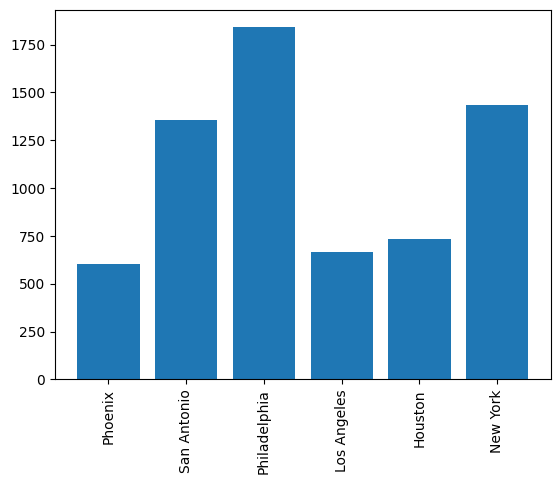

In [15]:
plt.bar(x=total_transactions_pd.store_location, height=total_transactions_pd.total_amount, )
plt.xticks(rotation=90)

In [16]:
total_transactions_per_store = transactions.groupBy('store_location').count().select('store_location', col('count').alias('transaction_count'))
total_transactions_per_store_pd = total_transactions_per_store.toPandas()
total_transactions_per_store_pd

,store_location,transaction_count
0,Phoenix,4
1,San Antonio,4
2,Philadelphia,4
3,Los Angeles,2
4,Houston,1
5,New York,6


## Number of transactions by store location.

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

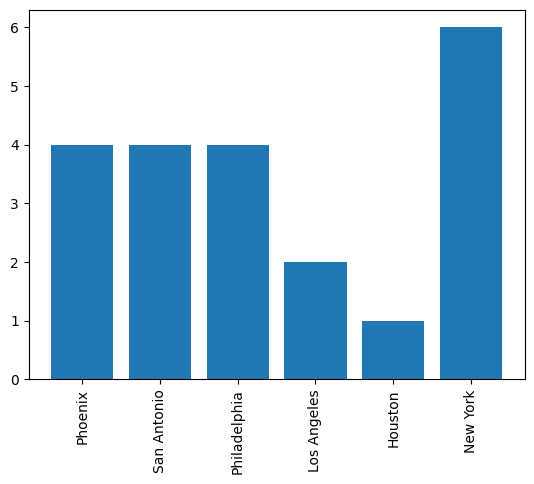

In [17]:
plt.bar(x=total_transactions_per_store_pd.store_location, height=total_transactions_per_store_pd.transaction_count)
plt.xticks(rotation=90)

## Top N (10) products by the number of transactions or transaction amounts.

In [85]:
popular_products = transactions.groupBy('product_ID').count().orderBy("count", ascending=False).select('product_ID', col('count').alias('transaction_count')).toPandas().head(10)

In [86]:
popular_products = pd.DataFrame(popular_products)
popular_products

,product_ID,transaction_count
0,P00082,15
1,P00047,15
2,P00031,15
3,P00055,15
4,P00003,15
5,P00054,15
6,P00096,15
7,P00061,15
8,P00085,14
9,P00065,14


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

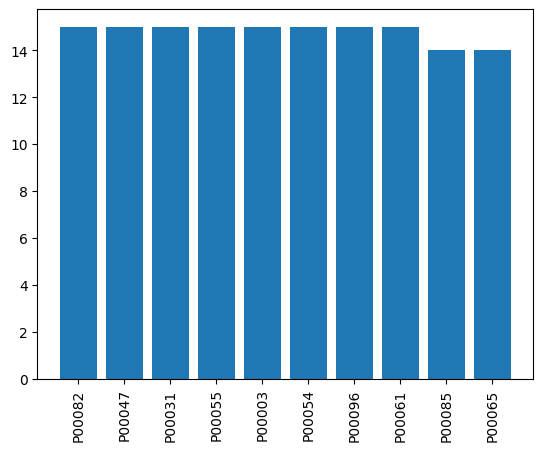

In [87]:
plt.bar(x=popular_products.product_ID, height=popular_products.transaction_count)
plt.xticks(rotation=90)

## Transaction counts over time (hourly, daily).

In [99]:
import datetime 

In [95]:
transactions_pd = transactions.toPandas()

In [100]:
transactions_pd.time_of_purchase.tail

<bound method NDFrame.tail of 0      2023-12-15 15:21:32
1      2023-12-15 15:21:33
2      2023-12-15 15:21:36
3      2023-12-15 15:21:37
4      2023-12-15 15:21:39
               ...        
1466   2023-12-15 16:10:14
1467   2023-12-15 16:10:16
1468   2023-12-15 16:10:18
1469   2023-12-15 16:10:21
1470   2023-12-15 16:10:23
Name: time_of_purchase, Length: 1471, dtype: datetime64[ns]>

In [106]:
transactions_pd.time_of_purchase.filter(datetime.datetime(2023,12,15,15,21,0) <= transactions_pd.time_of_purchase <= datetime.datetime(2023,12,15,15,22,0))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().